In [1]:
!pip install -q catboost shap
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import catboost
import catboost.datasets
import shap
import sklearn.model_selection
import seaborn as sns
import scipy

In [3]:
train_df = pd.read_csv("drive/MyDrive/DS-school-sber/hw5/train.csv")
test_df = pd.read_csv("drive/MyDrive/DS-school-sber/hw5/test.csv")

#train_df = pd.read_csv("sample_data/train.csv")
#test_df = pd.read_csv("sample_data/test.csv")

**Часть 1. Пропуски данных..**

In [4]:
print(train_df.shape, test_df.shape)

(1460, 81) (1459, 80)


In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
# неинформативные по субьективному мнению признаки
minor_cols = ['LowQualFinSF', 'Fireplaces', 'FireplaceQu', 'WoodDeckSF', 'MoSold', 'YrSold']

# Схожие числовые признаки - обьеденить столбы
baths_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
area_cols = ['1stFlrSF', '2ndFlrSF']
porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

# Столбцы с подозрительным распределением на анализ - посмортеть графики
strange_cols = ['MasVnrArea', 'BsmtFinSF2', 'WoodDeckSF', 'PoolArea'] 
# MiscVal столбец так же сильно разрежен, он позже будет удален по др причине)

# сразу обьединяю столбы перед проверкой остутсвующих  данных
train_df['TmpBsmt'] = train_df[baths_cols].sum(axis=1)
test_df['TmpBsmt'] = train_df[baths_cols].sum(axis=1)
train_df['TmpArea'] = train_df[area_cols].sum(axis=1)
test_df['TmpArea'] = test_df[area_cols].sum(axis=1)
train_df['TmpPorch'] = train_df[porch_cols].sum(axis=1)
test_df['TmpPorch'] = test_df[porch_cols].sum(axis=1)

In [7]:
s = train_df.isna().mean()
s[s > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [8]:
s = test_df.isna().mean()
s[s > 0]

MSZoning        0.002742
LotFrontage     0.155586
Alley           0.926662
Utilities       0.001371
Exterior1st     0.000685
Exterior2nd     0.000685
MasVnrType      0.010966
MasVnrArea      0.010281
BsmtQual        0.030158
BsmtCond        0.030843
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinSF1      0.000685
BsmtFinType2    0.028787
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
KitchenQual     0.000685
Functional      0.001371
FireplaceQu     0.500343
GarageType      0.052090
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageCars      0.000685
GarageArea      0.000685
GarageQual      0.053461
GarageCond      0.053461
PoolQC          0.997944
Fence           0.801234
MiscFeature     0.965045
SaleType        0.000685
dtype: float64

тк работаем с катбуст - избавляемся от пустых ячеек.
1. Там где пропусков меньше 10% делаю dropna
2. Alley, PoolQC, Fence, MiscFeature вообще удаляю колонки тк в них более 80% пропущено.
3. В остальных случаях заменяю значения средними.

In [9]:
# Иотого решил оставить след признаки
important_features = ['Condition1', 'TmpPorch', 'OverallQual', 'TmpArea', 'TotalBsmtSF', 'GrLivArea', 'GarageFinish', 'ExterQual', 'KitchenQual', 'MSZoning', 'BsmtQual', 'LotArea', 'OverallCond', 'BsmtFinType1', 'GarageArea', 'YearRemodAdd', 'Neighborhood', 'TmpBsmt', 'GarageCars', 'YearBuilt']

# В тч категориальные
cat_features = ['Condition1', 'GarageFinish', 'ExterQual', 'KitchenQual', 'MSZoning', 'BsmtQual', 'BsmtFinType1', 'Neighborhood']

# Смотрю какие их них имеют пропуски и чем их можно заменить
empty_cols = test_df[important_features].isna().mean()
empty_cols = empty_cols[empty_cols > 0].index.to_list()
for col in empty_cols:
  print(col)
  print(test_df[col].describe())
  print(test_df[col].isna().mean())
  print(test_df[col].unique())

TotalBsmtSF
count    1458.000000
mean     1046.117970
std       442.898624
min         0.000000
25%       784.000000
50%       988.000000
75%      1305.000000
max      5095.000000
Name: TotalBsmtSF, dtype: float64
0.0006854009595613434
[ 882. 1329.  928.  926. 1280.  763. 1168.  789. 1300. 1405.  483.  525.
  855.  836. 1590. 1544. 1698. 1822. 2846. 1671. 1370. 1324. 1145.  384.
  847. 1629. 1595. 1218. 1468.  831.  816. 1208. 1231. 1390. 1488.  840.
  600.  756.  530. 1642.  975. 1492. 1829. 1224.  715. 1232. 1209. 1510.
  533. 1728. 1140.  782. 1080. 1604. 1480. 1143. 1206. 1244.  832.  864.
  972.  988.  576. 1175. 1395.  709.  936. 1347.  827. 1027. 1008.  678.
  930.  346.  738. 1108.  765.  608.  572.  835.  780.  528. 1124.  888.
  662. 1422.  689. 1212.  707.  856. 1832. 1319.  720. 1420.  660. 1117.
  663. 1172. 1508. 1250. 1433.  946. 1222.  676.  870.  878. 1026.  876.
 1978. 1040.  848.    0.  381. 1196.  744.  960. 1107.  894. 1528. 1032.
  423.  982. 1191.  480.  629. 159

In [10]:
# Обработка пропусков

empty_cols = test_df[cat_features].isna().mean()
empty_cols = empty_cols[empty_cols > 0].index.to_list()
for col in empty_cols:
  test_df[col].fillna("None", inplace=True)

empty_cols = train_df[cat_features].isna().mean()
empty_cols = empty_cols[empty_cols > 0].index.to_list()
for col in empty_cols:
  train_df[col].fillna("None", inplace=True)

train_df.dropna(inplace=True, subset=important_features)
#train_df[important_features].fillna(train_df.mean(), inplace=True)
test_df[important_features].fillna(test_df.mean(), inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Часть 2. Анализ входных данных.**

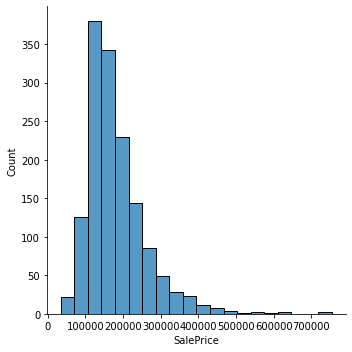

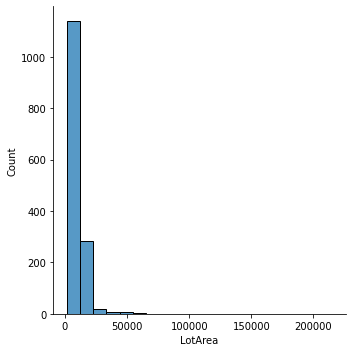

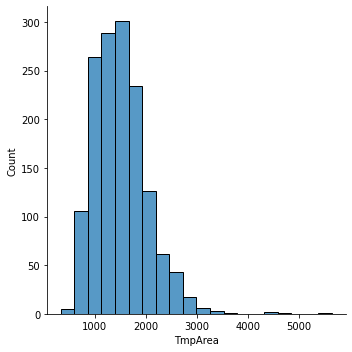

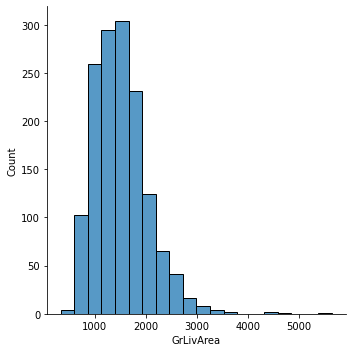

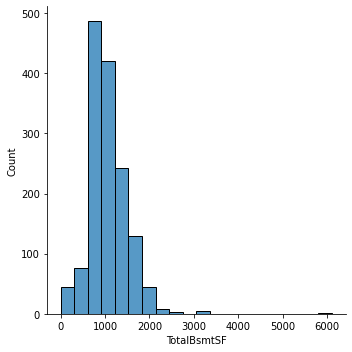

In [11]:
sns.displot(train_df['SalePrice'], bins=20)
# заодно смотрю числовые признаковые столбцы с выбросами
sns.displot(train_df['LotArea'], bins=20)
sns.displot(train_df['TmpArea'], bins=20)
sns.displot(train_df['GrLivArea'], bins=20)
sns.displot(train_df['TotalBsmtSF'], bins=20)

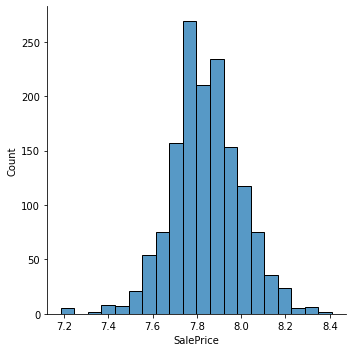

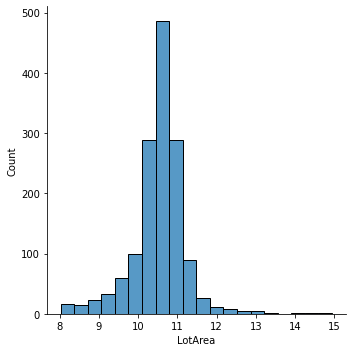

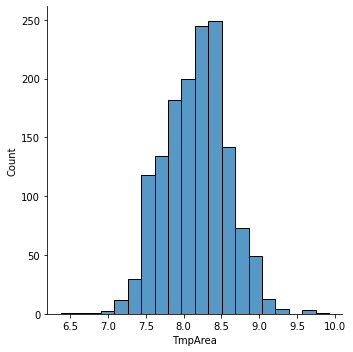

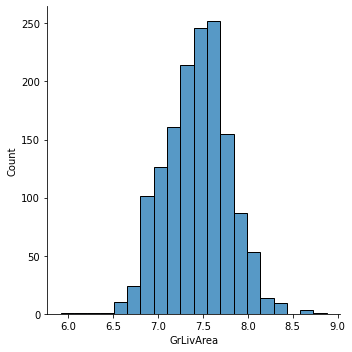

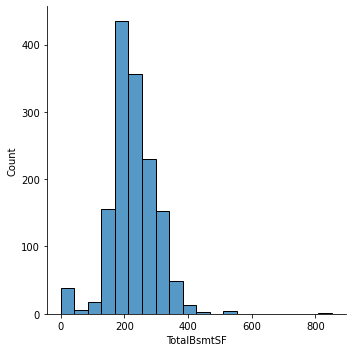

In [12]:
# "Разбираюсь" с выбросами - в итоге все на BoxCox

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] > (Q1 - 1.5 * IQR)) & (df[col] < (Q3 + 1.5 * IQR))]
#train_df = remove_outliers(train_df, 'SalePrice')

outliers_cols = ['LotArea', 'TmpArea', 'GrLivArea','TotalBsmtSF']
# TotalBsmtSF есть 0 значение, для boxcox нельзя
train_df['TotalBsmtSF'] += 1
test_df['TotalBsmtSF'] += 1

train_df['SalePrice'], boxcox_lambda = scipy.stats.boxcox(train_df['SalePrice'])
sns.displot(train_df['SalePrice'], bins=20)

for col in outliers_cols:
    train_df[col], tmp_lambda = scipy.stats.boxcox(train_df[col], lmbda=None)
    test_df[col] = scipy.stats.boxcox(test_df[col], lmbda=tmp_lambda)
    sns.displot(train_df[col], bins=20)

In [13]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train_df[important_features],
    train_df['SalePrice'],
    train_size=0.8,
    random_state=2021
)

test_X = test_df[important_features]

In [14]:
train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    val_X,
    label=val_y,
    cat_features=cat_features
)
test_pool = catboost.Pool(
    test_X,
    #label=test_y,
    cat_features=cat_features
)

In [15]:
?catboost.CatBoostRegressor
!rm -rf 'catboost_pricing/snapshot.bkp'

In [16]:
catboost_train_dir = 'catboost_pricing'
model = catboost.CatBoostRegressor(
    od_pval=0.05,
    od_wait=20,
    random_seed=2021,
    train_dir=catboost_train_dir,
    task_type='CPU',
    max_ctr_complexity=4,
    use_best_model=True
)
model.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04745
0:	learn: 0.1547608	test: 0.1459948	best: 0.1459948 (0)	total: 62.9ms	remaining: 1m 2s
1:	learn: 0.1496760	test: 0.1414975	best: 0.1414975 (1)	total: 74.3ms	remaining: 37.1s
2:	learn: 0.1450372	test: 0.1372114	best: 0.1372114 (2)	total: 93.4ms	remaining: 31.1s
3:	learn: 0.1409833	test: 0.1333447	best: 0.1333447 (3)	total: 109ms	remaining: 27.2s
4:	learn: 0.1368009	test: 0.1296433	best: 0.1296433 (4)	total: 123ms	remaining: 24.5s
5:	learn: 0.1330723	test: 0.1263771	best: 0.1263771 (5)	total: 141ms	remaining: 23.4s
6:	learn: 0.1292456	test: 0.1229477	best: 0.1229477 (6)	total: 170ms	remaining: 24.1s
7:	learn: 0.1254987	test: 0.1192410	best: 0.1192410 (7)	total: 205ms	remaining: 25.4s
8:	learn: 0.1223055	test: 0.1161711	best: 0.1161711 (8)	total: 223ms	remaining: 24.6s
9:	learn: 0.1190625	test: 0.1130184	best: 0.1130184 (9)	total: 246ms	remaining: 24.3s
10:	learn: 0.1159881	test: 0.1102337	best: 0.1102337 (10)	total: 254ms	remaining: 22.8s
11:	learn: 0.1132885

In [17]:
test_metrics = model.eval_metrics(
    val_pool,
    metrics=['SMAPE', 'R2'],
    ntree_start=model.best_iteration_ - 1,
    ntree_end=model.best_iteration_,
    eval_period=1,
    thread_count=-1
)
test_metrics

{'R2': [0.9125256244596712], 'SMAPE': [0.3932282504444105]}

Processing trees...
128/555 trees processed	passed time: 206ms	remaining time: 687ms
555/555 trees processed	passed time: 660ms	remaining time: 0us
Processing documents...
128/1168 documents processed	passed time: 20.1ms	remaining time: 163ms
1168/1168 documents processed	passed time: 159ms	remaining time: 0us


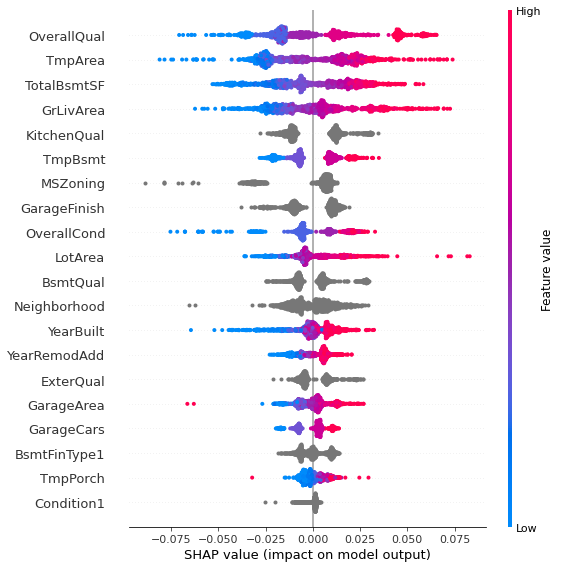

In [18]:
# Оцениваю влияние признаков

shap_info = model.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [19]:
test_y = model.predict(test_pool)
test_y = scipy.special.inv_boxcox(test_y, boxcox_lambda)
test_y = pd.Series(test_y)
test_df['SalePrice'] = test_y
test_df[['Id', 'SalePrice']].to_csv("result.csv", index=False)